First, we load the channels from Logdata. I picked these channels inspired by an Interview question I got at VCARB and only omitted the vertical accelerations because Ecurie's models do not account for elevation changes yet.

Load MDF into Notebook

In [1]:
# Re-enable interactive widgets in this session
%pip install -q --upgrade ipywidgets ipympl jupyterlab_widgets
%matplotlib widget
import matplotlib.pyplot as plt    
plt.close('all')

# If the notebook shows a "Not Trusted" banner: File → Trust Notebook, then re-run.
# Plotting bootstrap — run once after kernel restart
import matplotlib.pyplot as plt
plt.close('all')

def use_inline():
    try: get_ipython().run_line_magic('matplotlib', 'inline')
    except Exception: pass
    plt.ioff()

def use_widget():
    try: get_ipython().run_line_magic('matplotlib', 'widget')
    except Exception: pass

use_inline()  # default for batch plots; widget cells will switch themselves
print("Bootstrap done. Batch=inline. Widget cells switch to %matplotlib widget per cell.")


Note: you may need to restart the kernel to use updated packages.
Bootstrap done. Batch=inline. Widget cells switch to %matplotlib widget per cell.


In [2]:
#pip install -q asammdf
#TODO fix environment for VSCODE. runs in jupyter lab but not in VSCODE ^

import sys
print(sys.executable)


from asammdf import MDF
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from pathlib import Path

# Load MDF into the notebook
#mdf_path = Path.cwd().parent / "data" / "AutoXFSG23" / "DataF009_2023-08-19_18-03-59.mdf" # 3 runs
#mdf_path = Path.cwd().parent / "data" / "AutoXFSG23" / "DataF069_2023-08-19_15-15-44.mdf" # 1 run
mdf_path = Path.cwd().parent / "data" / "EnduranceFSG23" / "2023-08-20_14-36-15_Data_F123.mdf" # Endurance

mdf = MDF(mdf_path)

# Channel mapping used with SBG
CH = {
    "long_acc":              "ACCEL_X",              # longitudinal acceleration [m/s²]
    "lat_acc":               "ACCEL_Y",              # lateral acceleration [m/s²]
    "brake_pressure":        "PB_Brakeforce",        # braking force [% or N]
    "throttle_pedal":        "PB_Torque",            # engine torque or pedal proxy
    "car_speed":             "v_abs",                # absolute vehicle speed [m/s or km/h]
    "steering_wheel_angle":  "ECU_F_SteeringAngle",  # steering wheel angle [deg]
    "yaw_rate":              "yawrate",              # yaw rate [deg/s or rad/s]
    "pitch_rate":            "PITCH_ACC",            # pitch angular acceleration [deg/s²]
    "LAP_ID":                "Lapcounter"            # lap counter (only used for segmentation)
}


c:\Program Files\Python311\python.exe


Align and Trim Data in Dataframe

In [3]:
import numpy as np
import pandas as pd

# Select channels to align on a common time grid
names = ["ACCEL_X","ACCEL_Y","PB_Brakeforce","PB_Torque",
         "v_abs","ECU_F_SteeringAngle","yawrate","PITCH_ACC"]

def pull_df(mdf, name):
    s = mdf.get(name)
    return pd.DataFrame({"time_s": s.timestamps, name: s.samples})

# Load all selected channels
dfs = [pull_df(mdf, n) for n in names]

# Combine timestamps and align using nearest-time merging
raw_time = np.unique(np.concatenate([d["time_s"].values for d in dfs]))
raw = pd.DataFrame({"time_s": raw_time})
for d in dfs:
    raw = pd.merge_asof(raw.sort_values("time_s"),
                        d.sort_values("time_s"),
                        on="time_s",
                        direction="nearest")

# Interpolate onto a constant time grid (SBG had 200 Hz)
fs = 200.0  # IMU sampling frequency
t = np.arange(raw.time_s.min(), raw.time_s.max(), 1.0/fs)
aligned = pd.DataFrame({"time_s": t})
for col in raw.columns:
    if col != "time_s":
        aligned[col] = np.interp(t, raw["time_s"].values, raw[col].values)

# Rough trimming: remove stationary sections at the beginning and end
v = aligned["v_abs"].values
moving = v > 3.0  # motion threshold in m/s
idx = np.flatnonzero(moving)

if len(idx):
    start = int(idx[0])
    end = int(idx[-1]) + 1
    aligned = aligned.iloc[start:end].reset_index(drop=True)
else:
    aligned = aligned.reset_index(drop=True)


Sanity check

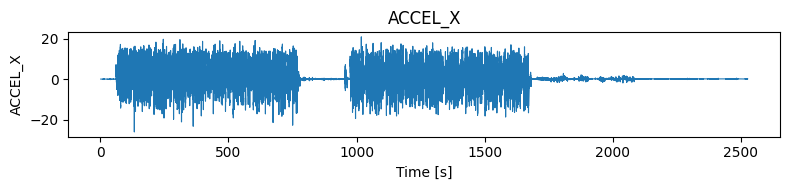

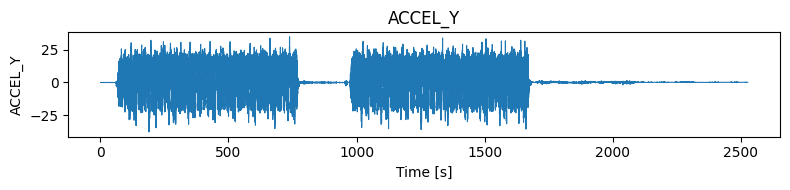

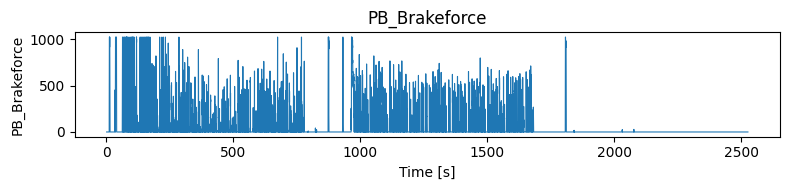

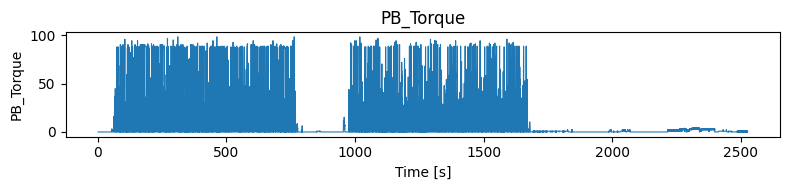

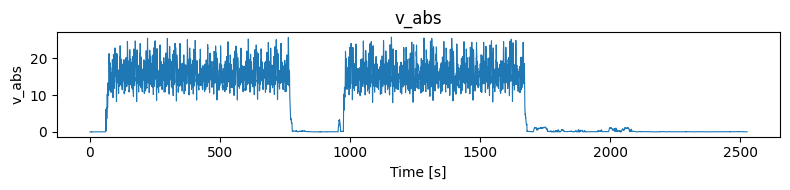

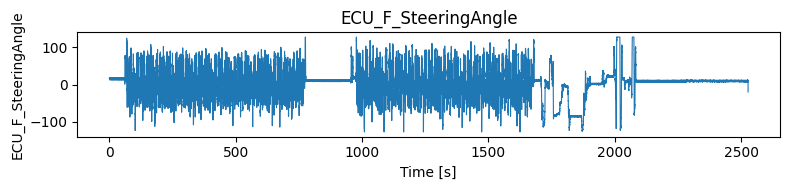

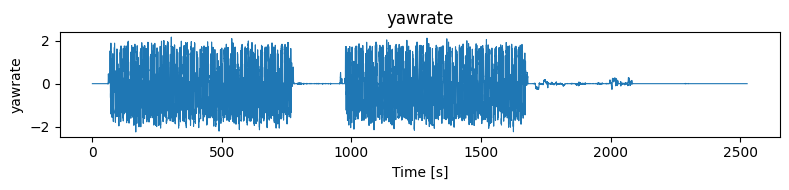

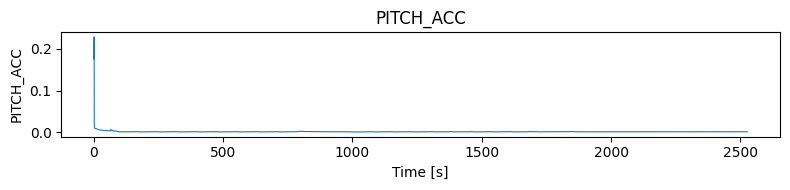

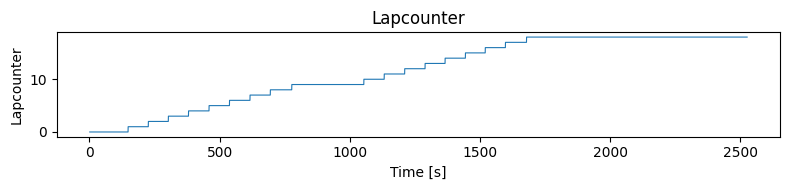

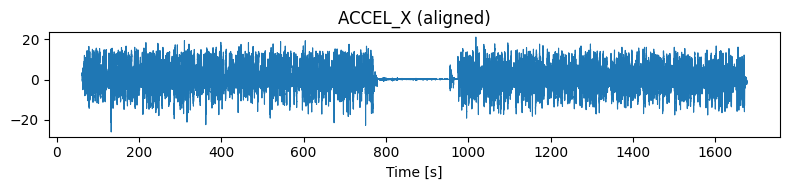

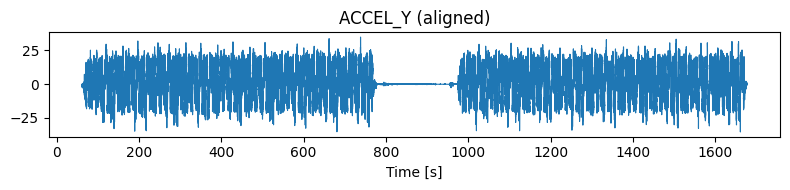

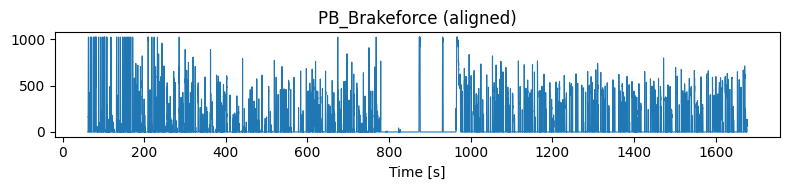

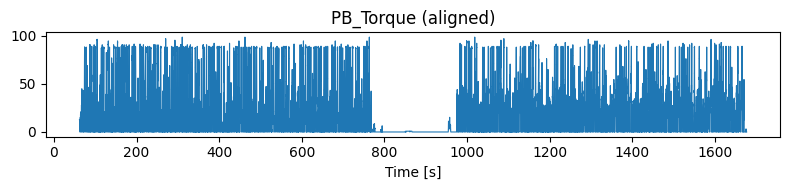

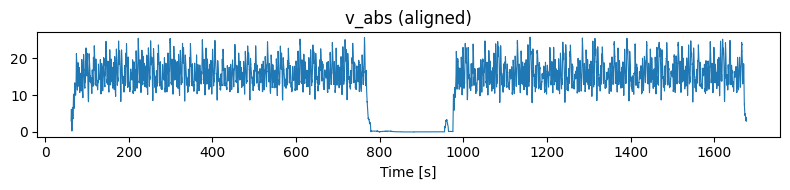

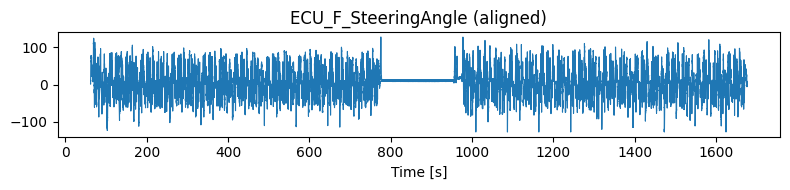

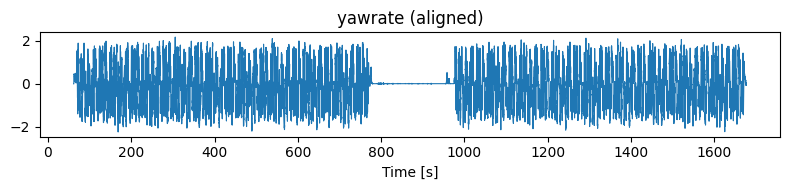

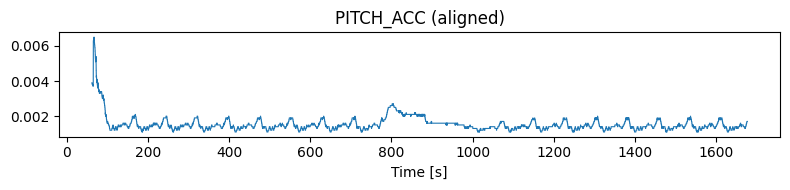

In [4]:
# Batch plots — self-contained (survives kernel restarts)

# Use inline backend for batch plotting (keeps widget cells separate)
try:
    get_ipython().run_line_magic('matplotlib', 'inline')
except Exception:
    pass

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

plt.close('all')
plt.ioff()  # non-interactive for loops

# Define 'pull' if it's not yet defined (after restart)
if 'pull' not in globals():
    def pull(mdf, ch):
        s = mdf.get(ch)
        return pd.DataFrame({"time_s": s.timestamps, "value": s.samples})

def _plot_series(ax, x, y, title, ylab=None):
    y = pd.to_numeric(pd.Series(y), errors='coerce').to_numpy()
    x = np.asarray(x)
    m = np.isfinite(x) & np.isfinite(y)
    if m.any():
        ax.plot(x[m], y[m], linewidth=0.8)
    else:
        ax.text(0.5, 0.5, "No finite data", ha="center", va="center", transform=ax.transAxes)
    ax.set_title(title)
    ax.set_xlabel("Time [s]")
    if ylab is not None:
        ax.set_ylabel(ylab)

# --- Raw channels (direct from MDF) ---
if 'mdf' in globals() and 'CH' in globals():
    for key, ch in CH.items():
        sig = pull(mdf, ch)
        fig, ax = plt.subplots(figsize=(8, 2))
        _plot_series(ax, sig["time_s"], sig["value"], f"{ch}", ylab=ch)
        fig.tight_layout(); fig.canvas.draw(); display(fig); plt.close(fig)
else:
    print("mdf/CH not defined. Rerun your loading cell.")

# --- Aligned and trimmed channels ---
if 'aligned' in globals():
    for col in aligned.columns:
        if col == "time_s":
            continue
        fig, ax = plt.subplots(figsize=(8, 2))
        _plot_series(ax, aligned["time_s"], aligned[col], f"{col} (aligned)")
        fig.tight_layout(); fig.canvas.draw(); display(fig); plt.close(fig)
else:
    print("aligned not defined. Rerun your preprocessing cell to create it.")

plt.ion()  # re-enable interactive mode for later cells


Smoothing and feature Engineering

In [5]:
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd
%matplotlib widget

# Light smoothing to reduce sensor noise while preserving shape
def smooth(x, window=11, poly=2):
    w = int(window) if int(window)%2==1 else int(window)+1
    w = max(5, w)
    return savgol_filter(x, w, poly) if len(x) > w else x

df = aligned.copy()

# Smoothed base signals
df["Speed"]     = smooth(df["v_abs"])              # forward velocity
df["LongAcc"]   = smooth(df["ACCEL_X"])            # longitudinal acceleration (IMU)
df["LatAcc"]    = smooth(df["ACCEL_Y"])            # lateral acceleration (IMU)
df["Brake"]     = smooth(df["PB_Brakeforce"])      # driver braking input
df["Torque"]    = smooth(df["PB_Torque"])          # driver torque/throttle proxy
df["Steer"]     = smooth(df["ECU_F_SteeringAngle"])
df["YawRate"]   = smooth(df["yawrate"])
df["PitchAcc"]  = smooth(df["PITCH_ACC"])

# Derived features (rates of change and magnitudes)
dt = np.gradient(df["time_s"].values)
df["dSpeed_dt"] = np.gradient(df["Speed"].values) / np.where(dt==0, np.nan, dt)    # speed rate
df["dSteer_dt"] = np.gradient(df["Steer"].values) / np.where(dt==0, np.nan, dt)    # steering rate
df["SteerAbs"]  = np.abs(df["Steer"].values)                                        # steering magnitude

# Cleanup invalid values
df = df.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

# Compact feature matrix for ML
feature_cols = [
    "Speed",      # overall vehicle state
    "LongAcc",    # braking/accel via IMU
    "LatAcc",     # cornering load
    "Brake",      # braking input
    "Torque",     # drive input
    "SteerAbs",   # cornering intensity
    "dSpeed_dt",  # transitions in longitudinal state
    "dSteer_dt",  # transitions in steering
    "YawRate",    # rotational velocity
]
df_features = df[["time_s"] + feature_cols].copy()


Feature Scaling

In [6]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

scaler = StandardScaler()

# Build scaled feature matrix (time excluded)
X = df_features.drop(columns=["time_s"]).values
X_scaled = scaler.fit_transform(X)

# Store scaled features
df_scaled = df_features.copy()
df_scaled[df_features.columns[1:]] = X_scaled


Lap segmentation (not yet used)

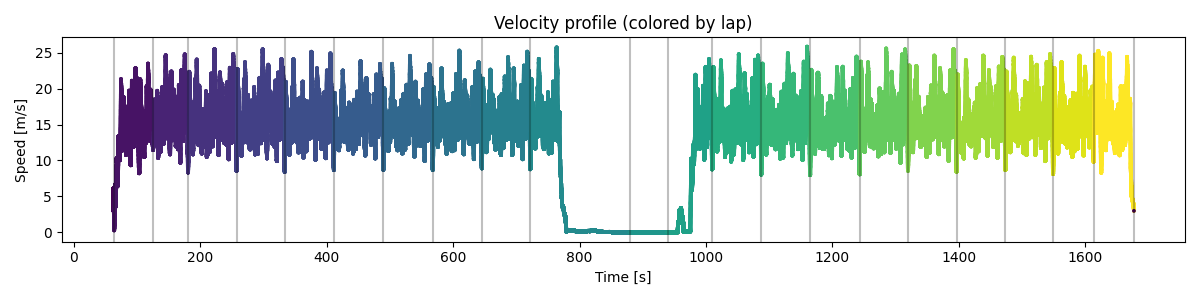

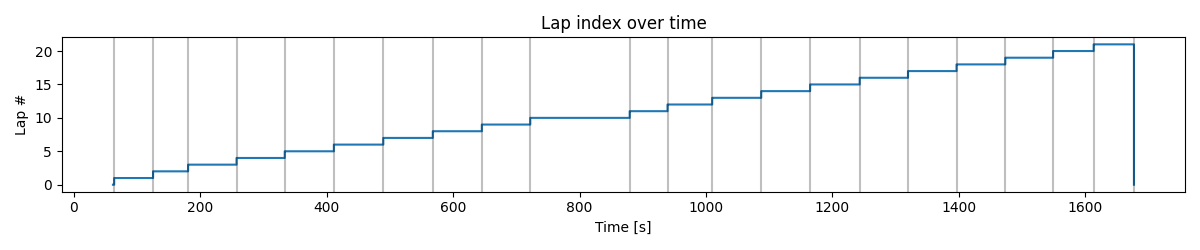

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Switch between LapCounter channel and heuristic
USELAPCOUNTER = 0
LAPTIME = 55  # expected lap time in seconds (for heuristic spacing)

t = aligned["time_s"].to_numpy()
speed = aligned["v_abs"].to_numpy()

if USELAPCOUNTER and "LapCounter" in aligned.columns:
    lap = aligned["LapCounter"].astype(int).to_numpy()
else:
    minima, _ = find_peaks(
        -speed,
        distance=int(LAPTIME / np.median(np.diff(t))),
        prominence=np.std(speed) * 0.3
    )
    bounds = np.r_[0, minima, len(speed) - 1]
    lap = np.zeros(len(speed), dtype=int)
    for i in range(len(bounds) - 1):
        lap[bounds[i]:bounds[i + 1]] = i

# Boundaries for visualization
bounds = np.where(np.diff(lap) != 0)[0] + 1

# Plot: speed colored by lap
plt.figure(figsize=(12,3))
plt.scatter(t, speed, c=lap, s=3)
for b in bounds:
    plt.axvline(t[b], color="k", alpha=0.25)
plt.xlabel("Time [s]")
plt.ylabel("Speed [m/s]")
plt.title("Velocity profile (colored by lap)")
plt.tight_layout()
plt.show()

# Plot: lap index over time
plt.figure(figsize=(12,2.5))
plt.step(t, lap, where="post", color="tab:blue")
for b in bounds:
    plt.axvline(t[b], color="k", alpha=0.25)
plt.xlabel("Time [s]")
plt.ylabel("Lap #")
plt.title("Lap index over time")
plt.tight_layout()
plt.show()


K Means Clustering and Visualization

In [8]:
# Setup: interactive matplotlib + basics
%pip install -q ipympl

# If you don't already have this list in your notebook, define it here:
feature_cols = [
    "Speed","LongAcc","LatAcc","Brake","Torque",
    "SteerAbs","dSpeed_dt","dSteer_dt","YawRate"
]

# Quick sanity checks (will raise if something crucial is missing)
assert "time_s" in df_features, "df_features must contain 'time_s'"
missing = set(feature_cols) - set(df_scaled.columns)
assert not missing, f"df_scaled is missing {missing}"


Note: you may need to restart the kernel to use updated packages.


K-Means fit + attach labels

In [9]:
from sklearn.cluster import KMeans
import numpy as np

K = 6
X = df_scaled[feature_cols].values

km = KMeans(n_clusters=K, random_state=0, n_init="auto")
labels_km = km.fit_predict(X)

# attach to df_features for downstream plots
df_features = df_features.copy()
df_features["label_km"] = labels_km


Interactive time plot (slider + zoom/pan)

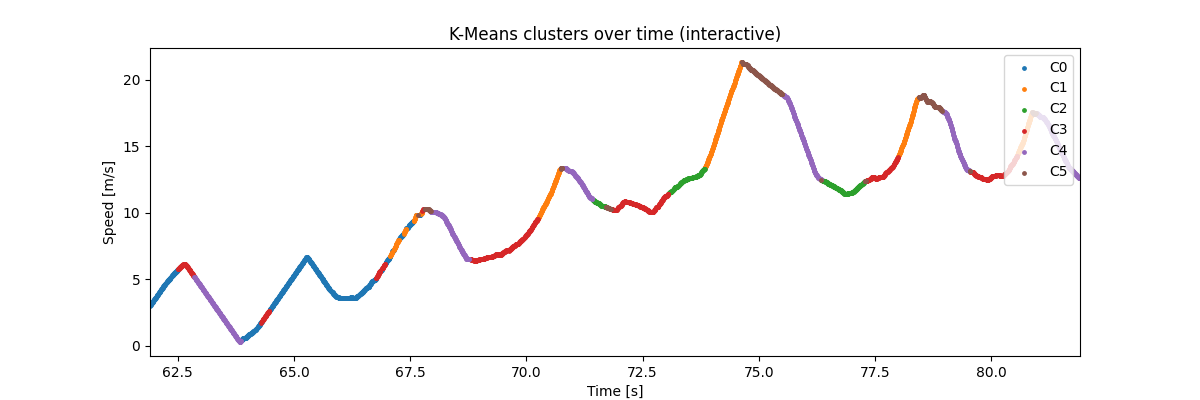

In [10]:
# Step 7a – Interactive time plot (ipympl)
import matplotlib.pyplot as plt
from ipywidgets import FloatRangeSlider, VBox
from IPython.display import display
import numpy as np

t = df_features["time_s"].to_numpy()
v = df_features["Speed"].to_numpy()
c = df_features["label_km"].to_numpy()

tmin, tmax = float(np.nanmin(t)), float(np.nanmax(t))
slider = FloatRangeSlider(
    value=[tmin, min(tmin + 20.0, tmax)],
    min=tmin, max=tmax, step=0.05,
    description="Time [s]", continuous_update=True, readout_format=".2f",
    layout={"width": "98%"}
)

fig, ax = plt.subplots(figsize=(12, 4))

def _update(*_):
    lo, hi = slider.value
    m = (t >= lo) & (t <= hi)
    ax.clear()
    for k in np.unique(c):
        mk = m & (c == k)
        if np.any(mk):
            ax.scatter(t[mk], v[mk], s=6, c=[plt.cm.tab10(k)], label=f"C{k}")
    ax.set_xlim(lo, hi)
    ax.set_xlabel("Time [s]"); ax.set_ylabel("Speed [m/s]")
    ax.set_title("K-Means clusters over time (interactive)")
    ax.legend(loc="upper right")
    fig.canvas.draw_idle()

slider.observe(_update, names="value")
_update()
display(VBox([slider, fig.canvas]))


Interactive feature-space explorer (choose any X/Y)

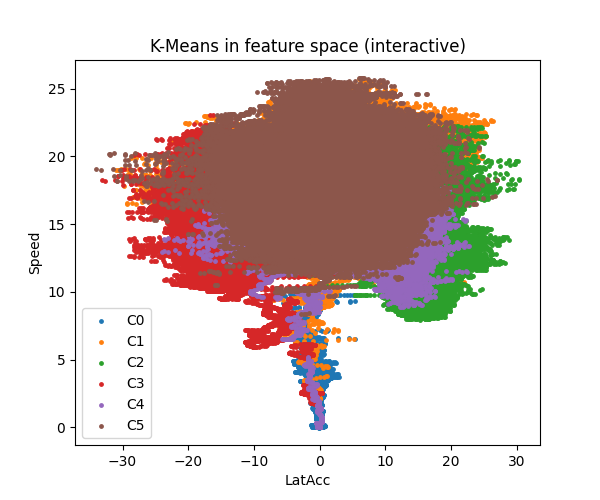

In [11]:
# Step 7b – Interactive feature-space explorer
import matplotlib.pyplot as plt
from ipywidgets import Dropdown, HBox, VBox
from IPython.display import display
import numpy as np

x_dd = Dropdown(options=feature_cols, value="LatAcc", description="X:")
y_dd = Dropdown(options=feature_cols, value="Speed",  description="Y:")

fig_fs, ax_fs = plt.subplots(figsize=(6, 5))
labels = df_features["label_km"].to_numpy()

def _draw_fs(*_):
    ax_fs.clear()
    x = df_features[x_dd.value].to_numpy()
    y = df_features[y_dd.value].to_numpy()
    for k in np.unique(labels):
        mk = (labels == k)
        if np.any(mk):
            ax_fs.scatter(x[mk], y[mk], s=6, c=[plt.cm.tab10(k)], label=f"C{k}")
    ax_fs.set_xlabel(x_dd.value); ax_fs.set_ylabel(y_dd.value)
    ax_fs.set_title("K-Means in feature space (interactive)")
    ax_fs.legend(loc="best")
    fig_fs.canvas.draw_idle()

x_dd.observe(_draw_fs, names="value")
y_dd.observe(_draw_fs, names="value")
_draw_fs()
display(VBox([HBox([x_dd, y_dd]), fig_fs.canvas]))


Interactive PCA view (zoom/pan)

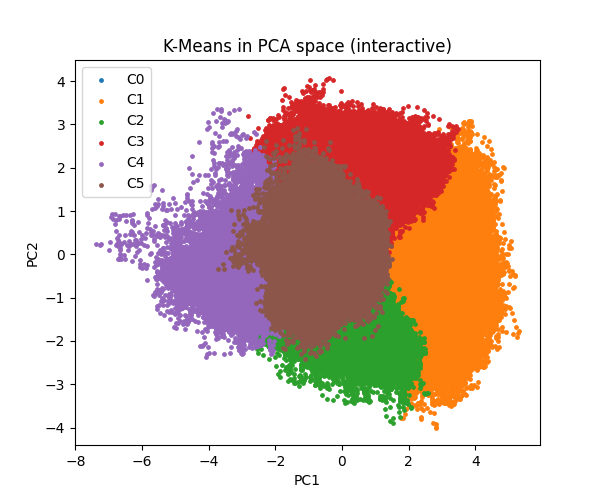

In [12]:
# Step 7c – Interactive PCA view
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

X = df_scaled[feature_cols].values
labels = df_features["label_km"].to_numpy()

pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(X)

fig_pca, ax_pca = plt.subplots(figsize=(6, 5))
for k in np.unique(labels):
    mk = (labels == k)
    ax_pca.scatter(Z[mk, 0], Z[mk, 1], s=6, c=[plt.cm.tab10(k)], label=f"C{k}")
ax_pca.set_xlabel("PC1"); ax_pca.set_ylabel("PC2")
ax_pca.set_title("K-Means in PCA space (interactive)")
ax_pca.legend(loc="best")
plt.show()


C:\Users\klein\AppData\Local\Temp\ipykernel_28808\711326107.py:33: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = np.abs(np.cross(line_vec, p - p1)) / line_len


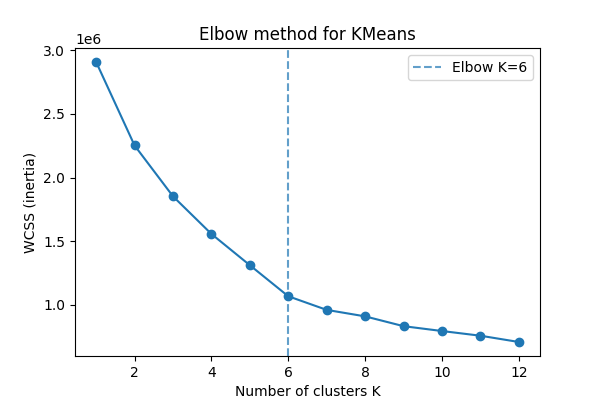

Suggested K by elbow method: 6


In [13]:
# Step 7d Elbow plot for KMeans using WCSS
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Use the same features you clustered on
X = df_scaled[feature_cols].values

# Range of K to evaluate (adjust K_max if needed)
K_min, K_max = 1, 12
ks = np.arange(K_min, K_max + 1)

inertias = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=0, n_init="auto")
    km.fit(X)
    inertias.append(km.inertia_)

# Simple elbow detection: max distance from the line through the endpoints
p1 = np.array([ks[0], inertias[0]], dtype=float)
p2 = np.array([ks[-1], inertias[-1]], dtype=float)
line_vec = p2 - p1
line_len = np.linalg.norm(line_vec)

# Avoid division by zero if all inertias are identical (pathological)
if line_len == 0:
    k_elbow = int(ks[0])
else:
    dists = []
    for i, k in enumerate(ks):
        p = np.array([k, inertias[i]], dtype=float)
        # Distance from point p to line p1->p2
        dist = np.abs(np.cross(line_vec, p - p1)) / line_len
        dists.append(dist)
    k_elbow = int(ks[int(np.argmax(dists))])

fig_elbow, ax_elbow = plt.subplots(figsize=(6, 4))
ax_elbow.plot(ks, inertias, marker="o")
ax_elbow.axvline(k_elbow, linestyle="--", alpha=0.7, label=f"Elbow K={k_elbow}")
ax_elbow.set_xlabel("Number of clusters K")
ax_elbow.set_ylabel("WCSS (inertia)")
ax_elbow.set_title("Elbow method for KMeans")
ax_elbow.legend(loc="best")
plt.show()

print(f"Suggested K by elbow method: {k_elbow}")


It turns out K = 6 delivers 6 meaningfull clusters:
C0: Idle
C1: Accelerating
C2, C3: Cornering
C4: hard braking
C5: Coasting



7TODO:
1. Interpretieren, K CLustering verstehen
3. GMM Clustering
4. Vergleich einzelner Fahrer/Rundencharacteristik



In [14]:
# === Step 8 — Constrained GMM (seeded from KMeans), K=6 ===
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import numpy as np, pandas as pd

# 0) Data
X = df_scaled[feature_cols].to_numpy()
N, D = X.shape

# 1) Use existing KMeans(K=6) if present, else fit it
try:
    km  # noqa: F821
    use_km = (hasattr(km, "n_clusters") and int(km.n_clusters) == 6)
except NameError:
    use_km = False

if not use_km:
    km = KMeans(n_clusters=6, random_state=0, n_init=50)
    labels_km = km.fit_predict(X)
else:
    labels_km = km.predict(X)

# cluster proportions for weights_init
pis = np.maximum(np.bincount(labels_km, minlength=6) / len(labels_km), 1e-6)

# 2) Constrained GMM: stay close to KMeans
gmm6 = GaussianMixture(
    n_components=6,
    covariance_type="diag",  # stable, KMeans-like; try "spherical" for even tighter behavior
    reg_covar=1e-5,
    n_init=1,                # start from our given means_init
    max_iter=50,             # keep small so it will not drift far
    init_params="kmeans",
    random_state=0,
    means_init=km.cluster_centers_,
    weights_init=pis,
)
gmm6.fit(X)

# 3) Labels and soft probabilities
labels_gmm6 = gmm6.predict(X)
proba_gmm6  = gmm6.predict_proba(X)

df_features = df_features.copy()
df_features["label_gmm6"] = labels_gmm6
for j in range(6):
    df_features[f"p_gmm6_{j}"] = proba_gmm6[:, j]

# 4) Component -> state mapping (penalize "corneriness" for ACCEL)
cluster_stats = (
    df_features[feature_cols + ["label_gmm6"]]
    .groupby("label_gmm6").mean()
)

eps = 1e-12
def s01(s):
    s = s.astype(float)
    return (s - s.min()) / (s.max() - s.min() + eps)

spd       = s01(cluster_stats["Speed"])
steer     = s01(cluster_stats["SteerAbs"])
torque    = s01(cluster_stats["Torque"])
brake     = s01(cluster_stats["Brake"])
lat_abs   = s01(cluster_stats["LatAcc"].abs())
yaw_abs   = s01(cluster_stats["YawRate"].abs())
ds_abs    = s01(cluster_stats["dSpeed_dt"].abs())
dsteer_abs= s01(cluster_stats["dSteer_dt"].abs())
ds_pos    = s01(np.clip(cluster_stats["dSpeed_dt"], 0, None))
ds_neg    = s01(np.clip(-cluster_stats["dSpeed_dt"], 0, None))
long_pos  = s01(np.clip(cluster_stats["LongAcc"], 0, None))
long_neg  = s01(np.clip(-cluster_stats["LongAcc"], 0, None))
lat_pos   = s01(np.clip(cluster_stats["LatAcc"], 0, None))
lat_neg   = s01(np.clip(-cluster_stats["LatAcc"], 0, None))

states = ["IDLE","ACCELERATE","CORNER_LEFT","CORNER_RIGHT","BRAKING","COASTING"]
scores = pd.DataFrame(index=cluster_stats.index, columns=states, dtype=float)

scores["IDLE"] = (
    0.25*(1-spd) + 0.20*(1-lat_abs) + 0.15*(1-ds_abs) + 0.15*(1-dsteer_abs)
  + 0.10*(1-yaw_abs) + 0.075*(1-brake) + 0.075*(1-torque)
)

scores["ACCELERATE"] = (
    0.50*long_pos + 0.30*torque + 0.12*ds_pos
  + 0.04*(1-brake) + 0.04*(1-steer)
) - (0.20*lat_abs + 0.08*yaw_abs)  # corneriness penalty

#this can be finetuned
scores["CORNER_LEFT"]  = 0.60*lat_pos + 0.25*steer + 0.12*yaw_abs + 0.03*(1-brake)
scores["CORNER_RIGHT"] = 0.60*lat_neg + 0.25*steer + 0.12*yaw_abs + 0.03*(1-brake)
scores["BRAKING"]      = 0.52*brake + 0.30*long_neg + 0.15*ds_neg + 0.03*(1-torque)
scores["COASTING"]     = 0.40*(1-brake) + 0.35*(1-torque) + 0.10*(1-ds_abs) + 0.10*(1-dsteer_abs) + 0.05*(1-long_pos.clip(0,1))

# Hungarian assignment for one-to-one mapping
from scipy.optimize import linear_sum_assignment
cost = -scores[states].to_numpy()
r, c = linear_sum_assignment(cost)
gmm6_phase_map = {scores.index[i]: states[j] for i, j in zip(r, c)}

# Guardrail: straight & strong throttle should be ACCELERATE, not CORNER
means = cluster_stats
F = df_features  # shorthand
straightish = (
    (means["LatAcc"].abs() <= F["LatAcc"].abs().quantile(0.35)) &
    (means["SteerAbs"]     <= F["SteerAbs"].quantile(0.45)) &
    (means["YawRate"].abs()<= F["YawRate"].abs().quantile(0.45))
)
acc_like = (
    (means["LongAcc"] >= F["LongAcc"].quantile(0.65)) &
    (means["Torque"]  >= F["Torque"].quantile(0.60)) &
    (means["dSpeed_dt"] >= F["dSpeed_dt"].quantile(0.55))
)
for k in means.index[straightish & acc_like]:
    if gmm6_phase_map.get(k) in {"CORNER_LEFT","CORNER_RIGHT"}:
        gmm6_phase_map[k] = "ACCELERATE"

# Per-sample phases
df_features["phase_gmm6"] = df_features["label_gmm6"].map(gmm6_phase_map)

print("GMM6 component -> state mapping:")
print(pd.Series(gmm6_phase_map).sort_index())


GMM6 component -> state mapping:
0            IDLE
1      ACCELERATE
2    CORNER_RIGHT
3     CORNER_LEFT
4        COASTING
5         BRAKING
dtype: object


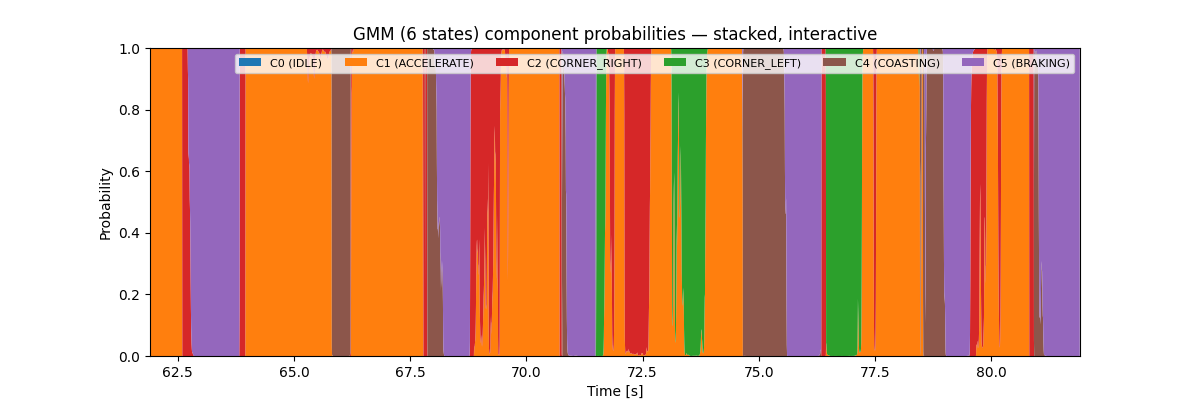

In [15]:
# Step 8b – GMM (6 states): interactive stacked probabilities over time (ipympl) — fixed

# Use widget backend without duplicate display
try:
    get_ipython().run_line_magic('matplotlib', 'widget')
except Exception:
    pass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import FloatRangeSlider, VBox
from IPython.display import display

# avoid duplicate old figures when re-running
plt.close('all')

# --- pre-flight for 6-state GMM ---
p_cols = sorted([c for c in df_features.columns if c.startswith("p_gmm6_")],
                key=lambda s: int(s.split("_")[-1]))
n_components = len(p_cols)
assert n_components > 0, "GMM6 probabilities (p_gmm6_*) not found. Run the 6-state GMM step first."
assert "time_s" in df_features and "phase_gmm6" in df_features

# component -> state mapping (use existing map if present; else infer from winners' majority phase)
try:
    gmm6_phase_map  # noqa: F821
except NameError:
    gmm6_phase_map = {}
    P_tmp = np.column_stack([df_features[c].to_numpy() for c in p_cols])
    winners = P_tmp.argmax(axis=1)
    phases = df_features["phase_gmm6"].astype(str)
    for j in range(n_components):
        mk = (winners == j)
        if np.any(mk):
            gmm6_phase_map[j] = phases[mk].mode().iat[0]
        else:
            gmm6_phase_map[j] = "COASTING"  # harmless default

# consistent ordering and colors for six driving states
phase_order = ["IDLE","ACCELERATE","CORNER_LEFT","CORNER_RIGHT","BRAKING","COASTING"]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
phase_color = {p: colors[i % len(colors)] for i, p in enumerate(phase_order)}

# data
t = df_features["time_s"].to_numpy(dtype=float)
P = np.column_stack([df_features[c].to_numpy(dtype=float) for c in p_cols])

comp_labels = [f"C{j} ({gmm6_phase_map.get(j,'?')})" for j in range(n_components)]
comp_colors = [
    phase_color.get(gmm6_phase_map.get(j, "COASTING"), colors[j % len(colors)])
    for j in range(n_components)
]

# slider
tmin, tmax = float(np.nanmin(t)), float(np.nanmax(t))
slider_pb = FloatRangeSlider(
    value=[tmin, min(tmin + 20.0, tmax)],
    min=tmin, max=tmax, step=0.05,
    description="Time [s]", continuous_update=True, readout_format=".2f",
    layout={"width": "98%"}
)

# figure
fig_pb, ax_pb = plt.subplots(figsize=(12, 4))
if hasattr(fig_pb.canvas, "header_visible"):  fig_pb.canvas.header_visible = False
if hasattr(fig_pb.canvas, "toolbar_visible"): fig_pb.canvas.toolbar_visible = True
if hasattr(fig_pb.canvas, "resizable"):       fig_pb.canvas.resizable = True

def _update_pb(*_):
    lo, hi = slider_pb.value
    m = np.isfinite(t) & (t >= lo) & (t <= hi)
    # ensure finite probabilities for stackplot
    Y = [np.nan_to_num(P[m, j], nan=0.0, posinf=0.0, neginf=0.0) for j in range(n_components)]
    x = t[m]
    ax_pb.clear()
    if x.size > 0:
        ax_pb.stackplot(x, Y, colors=comp_colors, labels=comp_labels)
        ax_pb.set_xlim(lo, hi)
        ax_pb.set_ylim(0.0, 1.0)
    ax_pb.set_xlabel("Time [s]"); ax_pb.set_ylabel("Probability")
    ax_pb.set_title("GMM (6 states) component probabilities — stacked, interactive")
    ax_pb.legend(loc="upper right", ncols=min(n_components, 6), fontsize=8, frameon=True)
    fig_pb.canvas.draw_idle()

slider_pb.observe(_update_pb, names="value")
_update_pb()

# show only slider + canvas (avoid duplicate fig auto-display)
display(VBox([slider_pb, fig_pb.canvas]))


In [16]:
#HMM
# === Step 9 — HMM smoothing (6 states), initialized from constrained GMM ===
# Removes COAST <-> IDLE flicker and enforces realistic transitions.
# Requires hmmlearn.
try:
    from hmmlearn.hmm import GaussianHMM
except Exception:
    import sys
    !{sys.executable} -m pip install -q hmmlearn
    from hmmlearn.hmm import GaussianHMM

import numpy as np

state_order = ["IDLE","ACCELERATE","CORNER_LEFT","CORNER_RIGHT","BRAKING","COASTING"]
state_to_idx = {s:i for i,s in enumerate(state_order)}

# Build means and diag covariances per state from the GMM6 we just fitted
means_by_state = np.zeros((6, D))
covs_by_state  = np.zeros((6, D))

for comp_k, st in gmm6_phase_map.items():
    i = state_to_idx[st]
    means_by_state[i] = gmm6.means_[comp_k]
    cov_k = gmm6.covariances_[comp_k]
    # If you switch to "spherical", expand scalar to length-D
    if np.ndim(cov_k) == 0:
        cov_k = np.full(D, float(cov_k))
    covs_by_state[i] = cov_k

# Start probabilities: empirical frequency of GMM states
emp_counts = df_features["phase_gmm6"].value_counts().reindex(state_order, fill_value=0).to_numpy().astype(float)
startprob = emp_counts / np.maximum(emp_counts.sum(), 1.0)

# Transition matrix: strong self-stickiness + plausible neighbors
s = 0.97  # self-stickiness (0.95..0.995 typical)
allowed = {
    "IDLE":         ["COASTING"],
    "COASTING":     ["IDLE","ACCELERATE"],
    "ACCELERATE":   ["COASTING","CORNER_LEFT","CORNER_RIGHT"],
    "CORNER_LEFT":  ["ACCELERATE","BRAKING"],
    "CORNER_RIGHT": ["ACCELERATE","BRAKING"],
    "BRAKING":      ["COASTING","CORNER_LEFT","CORNER_RIGHT"],
}
T = np.zeros((6,6))
for i, si in enumerate(state_order):
    nbrs = allowed[si]
    if len(nbrs) == 0:
        T[i,i] = 1.0
    else:
        T[i,i] = s
        share = (1.0 - s) / len(nbrs)
        for sj in nbrs:
            j = state_to_idx[sj]
            T[i,j] += share

# Build HMM with our parameters (no training updates)
hmm = GaussianHMM(
    n_components=6,
    covariance_type="diag",
    n_iter=1,
    random_state=0,
    init_params="",  # do not overwrite our manual init
    params=""        # do not update params during fit
)
hmm.startprob_ = startprob
hmm.transmat_  = T
hmm.means_     = means_by_state
hmm.covars_    = covs_by_state

# Decode most likely state sequence
X = df_scaled[feature_cols].to_numpy()
states_idx = hmm.predict(X)
states_hmm = [state_order[i] for i in states_idx]

df_features["phase_hmm6"] = states_hmm

print("HMM state counts:")
print(df_features["phase_hmm6"].value_counts().reindex(state_order, fill_value=0))


HMM state counts:
phase_hmm6
IDLE            33428
ACCELERATE      99271
CORNER_LEFT     59644
CORNER_RIGHT    34288
BRAKING         46661
COASTING        49688
Name: count, dtype: int64


In [17]:
#experimantal higher stickyness for idle and penalise low velocities for idle. this removed coasting, so commented out. could be retuned
# Step 9a – Reduce IDLE↔COASTING flicker
"""
import numpy as np, pandas as pd
from hmmlearn.hmm import GaussianHMM

# Preconditions: from Step 9 you already have
# state_order, state_to_idx, startprob, T, means_by_state, covs_by_state
# and df_features, df_scaled, feature_cols

assert all(x in globals() for x in ["state_order","state_to_idx","startprob","T","means_by_state","covs_by_state"]), \
       "Run Step 9 HMM first."

# 1) Speed smoothing and threshold
v = df_features["Speed"].to_numpy(dtype=float)
v_smooth = pd.Series(v).rolling(9, center=True, min_periods=1).median().to_numpy()
# conservative threshold that still allows crawl speeds to be idle
v_idle_thr = float(np.quantile(v_smooth, 0.15))

speed_idx = feature_cols.index("Speed")
i_idle  = state_to_idx["IDLE"]
i_coast = state_to_idx["COASTING"]
i_accel = state_to_idx["ACCELERATE"]

# 2) Emission penalty for low speed in COASTING
means_adj = means_by_state.copy()
covs_adj  = covs_by_state.copy()

# push COASTING mean speed up a bit and narrow variance on Speed
coast_target = max(means_adj[i_coast, speed_idx], np.quantile(v_smooth, 0.40))
means_adj[i_coast, speed_idx] = coast_target
covs_adj[i_coast, speed_idx]  = max(covs_adj[i_coast, speed_idx] * 0.25, 1e-6)

# pull IDLE mean speed nearer to zero and narrow a bit
means_adj[i_idle, speed_idx] = min(means_adj[i_idle, speed_idx], np.quantile(v_smooth, 0.08))
covs_adj[i_idle, speed_idx]  = max(covs_adj[i_idle, speed_idx] * 0.50, 1e-6)

# 3) Transition stickiness
T_adj = T.copy()
s_idle  = 0.995   # very sticky idle
s_coast = 0.985   # quite sticky coasting

# IDLE row: mostly stay in IDLE, only move to COASTING
T_adj[i_idle, :] = 0.0
T_adj[i_idle, i_idle]  = s_idle
T_adj[i_idle, i_coast] = 1.0 - s_idle

# COASTING row: prefer staying or going to ACCELERATE, less often to IDLE
T_adj[i_coast, :] = 0.0
T_adj[i_coast, i_coast] = s_coast
T_adj[i_coast, i_accel] = (1.0 - s_coast) * 0.75
T_adj[i_coast, i_idle]  = (1.0 - s_coast) * 0.25

# 4) Rebuild HMM with adjusted params and decode
hmm = GaussianHMM(
    n_components=len(state_order),
    covariance_type="diag",
    n_iter=1,
    random_state=0,
    init_params="",
    params=""
)
hmm.startprob_ = startprob
hmm.transmat_  = T_adj
hmm.means_     = means_adj
hmm.covars_    = covs_adj

X = df_scaled[feature_cols].to_numpy()
states_idx = hmm.predict(X)
df_features["phase_hmm6"] = [state_order[i] for i in states_idx]

# 5) Optional post rule: if smoothed speed is below threshold, force IDLE
mask_low = v_smooth < v_idle_thr
df_features.loc[mask_low & (df_features["phase_hmm6"] == "COASTING"), "phase_hmm6"] = "IDLE"

print("Done. Flicker reduction applied. Re-run plots that use phase_hmm6.")
"""

'\nimport numpy as np, pandas as pd\nfrom hmmlearn.hmm import GaussianHMM\n\n# Preconditions: from Step 9 you already have\n# state_order, state_to_idx, startprob, T, means_by_state, covs_by_state\n# and df_features, df_scaled, feature_cols\n\nassert all(x in globals() for x in ["state_order","state_to_idx","startprob","T","means_by_state","covs_by_state"]),        "Run Step 9 HMM first."\n\n# 1) Speed smoothing and threshold\nv = df_features["Speed"].to_numpy(dtype=float)\nv_smooth = pd.Series(v).rolling(9, center=True, min_periods=1).median().to_numpy()\n# conservative threshold that still allows crawl speeds to be idle\nv_idle_thr = float(np.quantile(v_smooth, 0.15))\n\nspeed_idx = feature_cols.index("Speed")\ni_idle  = state_to_idx["IDLE"]\ni_coast = state_to_idx["COASTING"]\ni_accel = state_to_idx["ACCELERATE"]\n\n# 2) Emission penalty for low speed in COASTING\nmeans_adj = means_by_state.copy()\ncovs_adj  = covs_by_state.copy()\n\n# push COASTING mean speed up a bit and narrow va

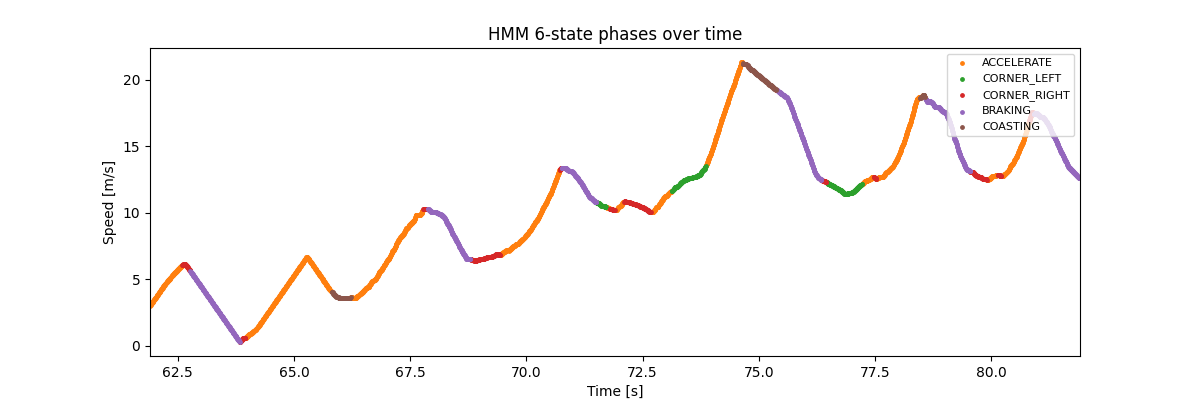

In [18]:
# Step 8a – Interactive Speed vs Time (auto-detects phase column)

# Use widget backend
try:
    get_ipython().run_line_magic('matplotlib', 'widget')
except Exception:
    pass

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import FloatRangeSlider, VBox, HTML
from IPython.display import display

plt.close('all')  # clear old figs

# --- Pick a phase column automatically ---
PHASE_COL = None
for cand in ("phase_hmm6", "phase_gmm6"):
    if cand in df_features.columns:
        PHASE_COL = cand
        break
assert PHASE_COL is not None, "No phase column found. Create 'phase_hmm6' (Step 9) or 'phase_gmm6' (Step 8)."

# --- Data (robust types) ---
t  = np.asarray(df_features["time_s"], dtype=float)
v  = np.asarray(df_features["Speed"], dtype=float)
ph = pd.Series(df_features[PHASE_COL]).astype(str).str.strip().to_numpy()

# Preferred 6-state order; will fall back to whatever exists if needed
pref_order = ["IDLE","ACCELERATE","CORNER_LEFT","CORNER_RIGHT","BRAKING","COASTING"]
present = [p for p in pref_order if np.any(ph == p)]
if not present:  # fallback to unique values in the data
    present = sorted(pd.unique(ph).tolist())

cmap = plt.get_cmap('tab10')
phase_color = {p: cmap(i % 10) for i, p in enumerate(present)}

# Slider window
tmin, tmax = float(np.nanmin(t)), float(np.nanmax(t))
slider = FloatRangeSlider(
    value=[tmin, min(tmin + 20.0, tmax)],
    min=tmin, max=tmax, step=0.05,
    description="Time [s]", continuous_update=True, readout_format=".2f",
    layout={"width": "98%"}
)

# Figure
fig, ax = plt.subplots(figsize=(12, 4))
if hasattr(fig.canvas, "header_visible"):  fig.canvas.header_visible = False
if hasattr(fig.canvas, "toolbar_visible"): fig.canvas.toolbar_visible = True
if hasattr(fig.canvas, "resizable"):       fig.canvas.resizable = True

info = HTML("")
if not present:
    info.value = f"<b>Note:</b> PHASE_COL='{PHASE_COL}' has no recognized phases."

def _update(*_):
    lo, hi = slider.value
    m = np.isfinite(t) & np.isfinite(v) & (t >= lo) & (t <= hi)
    ax.clear()
    drew_any = False
    for p in present:
        mk = m & (ph == p)
        if mk.any():
            ax.scatter(t[mk], v[mk], s=6, c=[phase_color[p]], label=p, rasterized=True)
            drew_any = True
    ax.set_xlim(lo, hi)
    ax.set_xlabel("Time [s]"); ax.set_ylabel("Speed [m/s]")
    title_src = "HMM" if PHASE_COL == "phase_hmm6" else "GMM"
    ax.set_title(f"{title_src} 6-state phases over time")
    if present:
        ax.legend(loc="upper right", fontsize=8, frameon=True)
    if not drew_any:
        ax.text(0.5, 0.5, "No samples in window", ha="center", va="center",
                transform=ax.transAxes, alpha=0.7)
    fig.canvas.draw_idle()

slider.observe(_update, names="value")
_update()
display(VBox([slider, fig.canvas, info]))


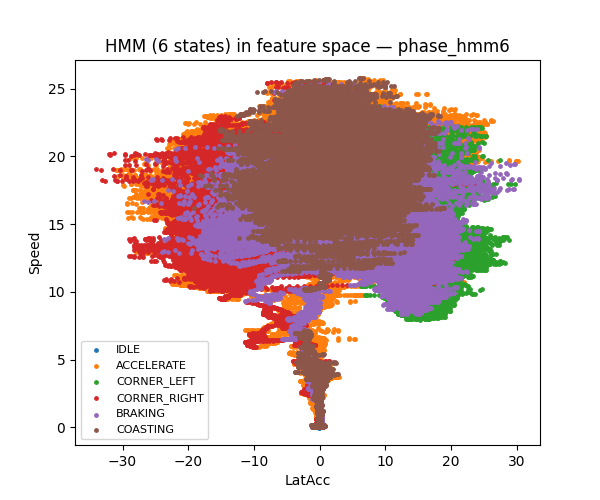

In [19]:
# Step 8c – 6-state feature-space explorer (auto: HMM if present else GMM)

# Use widget backend
try:
    get_ipython().run_line_magic('matplotlib', 'widget')
except Exception:
    pass

import matplotlib.pyplot as plt
from ipywidgets import Dropdown, HBox, VBox
from IPython.display import display
import numpy as np
import pandas as pd

plt.close('all')  # avoid duplicate old figures

# Pick phase column automatically
PHASE_COL = "phase_hmm6" if "phase_hmm6" in df_features.columns else (
            "phase_gmm6" if "phase_gmm6" in df_features.columns else None)
assert PHASE_COL is not None, "No phase column found. Create 'phase_hmm6' (Step 9) or 'phase_gmm6' (Step 8)."

# available features (use only those present)
feature_cols_all = [
    "Speed","LongAcc","LatAcc","Brake","Torque",
    "SteerAbs","dSpeed_dt","dSteer_dt","YawRate"
]
feature_cols_avail = [c for c in feature_cols_all if c in df_features.columns]
assert len(feature_cols_avail) >= 2, "Need at least two features in df_features."

# six-state phases & colors
phase_order = ["IDLE","ACCELERATE","CORNER_LEFT","CORNER_RIGHT","BRAKING","COASTING"]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
phase_color = {p: colors[i % len(colors)] for i, p in enumerate(phase_order)}
present = [p for p in phase_order if (df_features[PHASE_COL] == p).any()]

# dropdowns
default_x = "LatAcc" if "LatAcc" in feature_cols_avail else feature_cols_avail[0]
default_y = "Speed"  if "Speed"  in feature_cols_avail else (feature_cols_avail[1] if len(feature_cols_avail) > 1 else feature_cols_avail[0])
x_dd = Dropdown(options=feature_cols_avail, value=default_x, description="X:")
y_dd = Dropdown(options=feature_cols_avail, value=default_y, description="Y:")

# figure
fig_fs, ax_fs = plt.subplots(figsize=(6, 5))
if hasattr(fig_fs.canvas, "header_visible"):  fig_fs.canvas.header_visible = False
if hasattr(fig_fs.canvas, "toolbar_visible"): fig_fs.canvas.toolbar_visible = True
if hasattr(fig_fs.canvas, "resizable"):       fig_fs.canvas.resizable = True

def _draw_fs(*_):
    ax_fs.clear()
    for p in present:
        mk = (df_features[PHASE_COL] == p)
        if mk.any():
            x = np.asarray(df_features.loc[mk, x_dd.value], dtype=float)
            y = np.asarray(df_features.loc[mk, y_dd.value], dtype=float)
            ax_fs.scatter(x, y, s=6, c=[phase_color[p]], label=p, rasterized=True)
    ax_fs.set_xlabel(x_dd.value); ax_fs.set_ylabel(y_dd.value)
    src = "HMM" if PHASE_COL == "phase_hmm6" else "GMM"
    ax_fs.set_title(f"{src} (6 states) in feature space — {PHASE_COL}")
    if present:
        ax_fs.legend(loc="best", fontsize=8, frameon=True)
    fig_fs.canvas.draw_idle()

x_dd.observe(_draw_fs, names="value")
y_dd.observe(_draw_fs, names="value")
_draw_fs()

display(VBox([HBox([x_dd, y_dd]), fig_fs.canvas]))


Status:
GMM sieht sinnvoll aus In v über t. gg diagramm etwas skewed.
Plots sind komisch: restart zerschießts ab 7a. Wenn mann dann Einzelne Zelle nochmal laufen lässt, klappt es. Das Problem ist jetzt meine Zeit aber nicht Wert
funktioniert mitlerweile in vscode
TODO:
vscode working version (duplikate entfernen)
code cleanup, simplify!!
generate KPIs
add driver/lap comparison
if necessary, tune Coasting/Idle stickyness properly

Fazit: 
unsupervised learning ist nicht das richtige Tool, um Cornerphasen zu erkennen. 
Wir können trotzdem sinnvole CLuster finden und generell CLustering techniken nutzen, um anomalien festzustellen. dazu könnte k-means mit k=6 bereits reichen.
